In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

import _fix_paths
from lib.data import PEMSBay
from lib.models import STGCN_VAE

In [2]:
HIST_WINDOW = 12
PRED_WINDOW = 12
LEARNING_RATE = 0.001
WEIGHT_DECAY = 5e-4
NUM_EPOCHS = 50
BATCH_SIZE = 8
TEMPORAL_KERNEL = 3
SPATIAL_KERNEL = 3
RANDOM_SEED = 17

In [3]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [4]:
experiment_name = input().replace(' ', '_')

In [5]:
train_set = PEMSBay('../datasets/PEMS-BAY', 'train', HIST_WINDOW, PRED_WINDOW)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/io/pytables.py:3007: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = factory(


In [6]:
model = STGCN_VAE(
    SPATIAL_KERNEL, TEMPORAL_KERNEL, HIST_WINDOW, PRED_WINDOW, [(HIST_WINDOW + PRED_WINDOW, 16, 64), (64, 32, 128)],
    [1, 16, 32]
)


In [7]:
print(model)

STGCN_VAE(
  (encoder): ModuleList(
    (0): SpatioTemporalConv(
      (temporal_conv1): TemporalConv(
        (align): Align(
          (conv): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), padding=valid)
        )
        (gconv): ChebConv(24, 16, K=3, normalization=sym)
      )
      (spatial_conv): SpatialConv(
        (align): Align(
          (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=valid)
        )
        (gconv): ChebConv(16, 16, K=3, normalization=sym)
      )
      (temporal_conv2): TemporalConv(
        (align): Align(
          (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), padding=valid)
        )
        (gconv): ChebConv(16, 64, K=3, normalization=sym)
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): SpatioTemporalConv(
      (temporal_conv1): TemporalConv(
        (align): Align(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = model.to(device)

Using device: cpu


In [9]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [10]:
X, y = next(iter(train_loader))
X = X.to(device)
y = y.to(device)
edge_idx = train_set.edge_idx.to(device)
edge_wt = train_set.edge_wt.to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_mse = nn.MSELoss()

In [12]:
X.shape, y.shape

(torch.Size([8, 1, 325, 12]), torch.Size([8, 1, 325, 12]))

In [13]:
train_data = {
    'data_loader': train_loader,
    'edge_idx': edge_idx,
    'edge_wt': edge_wt
}

In [14]:
def train(model, n_epochs, optimizer, loss_fn, data):
    data_loader = data.get('data_loader', None)
    edge_idx = data.get('edge_idx', None)
    edge_wt = data.get('edge_wt', None)
    # writer = SummaryWriter("../logs")

    model.train()
    losses = []
    for epoch in tqdm(range(1, n_epochs + 1)):
        epoch_loss = 0.0
        for batch_num, (x, y) in enumerate(data_loader, start=1):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(x, y, edge_idx, edge_wt, sample=True)
            loss = loss_fn(y, y_hat)
            loss.backward()
            optimizer.step()

            # writer.add_scalar("Loss/train", loss.item(), (epoch - 1) * len(data_loader) + batch_num)
            epoch_loss = (epoch_loss * (batch_num - 1) + loss.item()) / batch_num
        print(f"[Epoch {epoch}/{n_epochs}]: loss = {epoch_loss:.4f}")
        losses.append(epoch_loss)
        torch.save(model.state_dict(), f"../weights/{experiment_name}.pt")
    return losses

In [15]:
losses = train(model, NUM_EPOCHS, optimizer, loss_mse, train_data)

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch 1/50]: loss = 153.0975
[Epoch 2/50]: loss = 42.9724
[Epoch 3/50]: loss = 31.5994
[Epoch 4/50]: loss = 23.9943
[Epoch 5/50]: loss = 19.4516
[Epoch 6/50]: loss = 17.3604
[Epoch 7/50]: loss = 15.6942
[Epoch 8/50]: loss = 14.6884
[Epoch 9/50]: loss = 14.1440
[Epoch 10/50]: loss = 13.6474
[Epoch 11/50]: loss = 13.2444
[Epoch 12/50]: loss = 13.1375
[Epoch 13/50]: loss = 12.7289
[Epoch 14/50]: loss = 12.4375
[Epoch 15/50]: loss = 11.9860
[Epoch 16/50]: loss = 11.8359
[Epoch 17/50]: loss = 11.6141
[Epoch 18/50]: loss = 11.5776
[Epoch 19/50]: loss = 11.1646
[Epoch 20/50]: loss = 11.0054
[Epoch 21/50]: loss = 10.7760
[Epoch 22/50]: loss = 10.6797
[Epoch 23/50]: loss = 10.5446
[Epoch 24/50]: loss = 10.6014
[Epoch 25/50]: loss = 10.1828
[Epoch 26/50]: loss = 10.1895
[Epoch 27/50]: loss = 10.1964
[Epoch 28/50]: loss = 9.9383
[Epoch 29/50]: loss = 9.7520
[Epoch 30/50]: loss = 9.7607
[Epoch 31/50]: loss = 9.6277
[Epoch 32/50]: loss = 9.5635
[Epoch 33/50]: loss = 9.6256
[Epoch 34/50]: loss = 9.

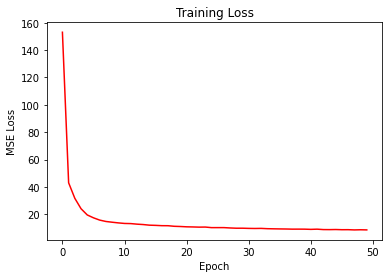

In [16]:
fig = plt.figure()
plt.plot(losses, 'r-')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.savefig(f"../figures/{experiment_name}.png")
plt.show()

In [18]:
model.load_state_dict(torch.load(f"../weights/{experiment_name}.pt"))

<All keys matched successfully>

In [19]:
val_set = PEMSBay('../datasets/PEMS-BAY', 'val', HIST_WINDOW, PRED_WINDOW)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/io/pytables.py:3007: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = factory(


In [20]:
val_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, drop_last=True)

In [28]:
val_data = {
    'data_loader': val_loader,
    'edge_idx': val_set.edge_idx.to(device),
    'edge_wt': val_set.edge_wt.to(device),
}

In [40]:
def eval(model, data):
    data_loader = data.get('data_loader', None)
    edge_idx = data.get('edge_idx', None)
    edge_wt = data.get('edge_wt', None)
    model.eval()
    mae, rmse, = torch.tensor([0.0]), torch.tensor([0.0])
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x, y, edge_idx, edge_wt, sample=True)
            mae += F.l1_loss(y_hat, y)
            rmse += F.mse_loss(y_hat, y)
        mae /= len(data_loader)
        rmse = (rmse/len(data_loader)).sqrt()
    return mae.item(), rmse.item()

In [41]:
mae, rmse = eval(model, val_data)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 1.6234
RMSE: 2.8928
